<a href="https://colab.research.google.com/github/ThulioSilva13/ProjetoCienciaDeDados/blob/main/TPDados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Descrição do projeto**
> O projeto tem o foco em desenvolver um modelo capaz de medir a taxa de evasão dos alunos do curso de Ciência da Computação da Universidade Federal de Viçosa - Campus Florestal,  onde são classificados de acordo com alguns parâmetros como idade, gênero, data de ingresso no curso, raça, cidade onde vivia antes de se mudar para as aulas, nota obtida no ENEM, CRA, modalidade de ingresso e o número de reprovações.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Bibliotecas utilizadas**

In [ ]:
!pip install fuzzywuzzy
!pip install pandas_ods_reader
!pip install unidecode

  Using cached Unidecode-1.3.6-py3-none-any.whl (235 kB)


In [ ]:
### NÃO REMOVA ESSA CÉLULA!! ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
from fuzzywuzzy import fuzz
from pandas_ods_reader import read_ods
from fuzzywuzzy import process
from scipy.stats import chi2_contingency
import scipy.stats as stats
import statsmodels.stats.proportion as proportion
import seaborn as sns
from unidecode import unidecode
import unicodedata

## **Leitura dos dados**

In [ ]:
dados = read_ods('dados1.ods')
dados

,Identificador,Ano_Nascimento,Sexo,Campus,Curso_Identificador,Curso,UF_Nascimento,Municipio_Nascimento,Admissao,Saida,Codigo_Situacao_Aluno,Situacao_Aluno,Situacao_Aluno_Agrupada,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA
0,29271.0,1982.0,M,CAV,1101.0,CAV - Administração,RJ,VOLTA REDONDA,2000/1,2000/1,A,Abandono ...,Evasão,0.0,NaN,0.0,Informação não disponível,0.0
1,29272.0,1982.0,M,CAV,1101.0,CAV - Administração,DF,Brasília,2000/1,2002/1,A,Abandono ...,Evasão,0.0,NaN,3.0,Informação não disponível,71.2
2,34462.0,1979.0,F,CAV,1101.0,CAV - Administração,MG,Viçosa,2000/1,2005/1,C,Conclusão ...,Conclusão,0.0,NaN,3.0,Informação não disponível,78.5
3,34468.0,1979.0,F,CAV,1101.0,CAV - Administração,MG,Belo Horizonte,2000/1,2006/1,C,Conclusão ...,Conclusão,0.0,NaN,20.0,Pardo(a),56.0
4,34470.0,1980.0,F,CAV,1101.0,CAV - Administração,SP,São Paulo,2000/1,2004/2,C,Conclusão ...,Conclusão,0.0,NaN,1.0,Informação não disponível,76.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74021,172112.0,1996.0,None,CAV,1153.0,CAV - Bacharelado em Educação Física,None,None,2023/1,0.0,N,Normal ...,Matriculado,0.0,NaN,0.0,Informação não disponível,0.0
74022,172110.0,1995.0,None,CAV,1153.0,CAV - Bacharelado em Educação Física,None,None,2023/1,0.0,N,Normal ...,Matriculado,0.0,NaN,0.0,Informação não disponível,NaN
74023,172113.0,1996.0,None,CAV,1153.0,CAV - Bacharelado em Educação Física,None,None,2023/1,0.0,N,Normal ...,Matriculado,0.0,NaN,0.0,Informação não disponível,NaN
74024,172114.0,1998.0,None,CAV,1153.0,CAV - Bacharelado em Educação Física,None,None,2023/1,0.0,N,Normal ...,Matriculado,0.0,NaN,0.0,Informação não disponível,NaN


## **Análise inicial dos dados**


> Inicialmente foi feita uma análise inicial dos atributos, observando fatores como o nome da coluna, o tipo de dado, os valores, dentre outros aspectos. Abaixo são listadas as observações:

> 1. Ao analisar os dados, percebeu-se que alguns possuem incompatibilidade em alguns campos, como por exemplo:
 - Não são todos os alunos que possuem valores na coluna contendo a nota do ENEM
 - Alguns campos que deveriam ter o preenchimento obrigatório, como as colunas Sexo e UF_Nascimento, estão valores NaN.
  - Alguns alunos possuem modalidade de ingresso com valor igual a zero. Desse modo, após pesquisar sobre o significado da modadlidade 0, descobriu-se que se refere ao campo de "Ampla Concorrência", entretanto, o valor de modalidade 9 também se refere a esse mesmo campo. Portanto, vale observar essa semelhança entre os dados para que futuramente no projeto evite falhas na observação e conclusão na análise desses dados.

> 2. Outra observação realizada, foi a relação entre a modalidade de ingresso e a nota obtida no ENEM, alguns alunos tem o campo preenchido com a nota do ENEM que usaram quando entraram na universidade, mas porém não consta em qual modalidade ele foi classificado. O mesmo se aplica no caso contrário, alguns alunos não possuem a nota do ENEM, mas na coluna da modalidade de ingresso, consta um valor.

> 3. Ao examinarmos o campo Situacao_Aluno, é possível perceber que ele possui diversos tipos de valores, como por exemplo, Conclusão, Desligamento, Abandono, Transferência, entre outros. Já ao observarmos o campo Situacao_Aluno_Agrupado, os valores se resumem a Conclusão, Evasão, Retenção e Matriculado. Após análises, percebeu-se que uma coluna tem relação direta com a outra, pois:
  - O valor Conclusão no campo Situacao_Aluno_Agrupado, se refere também aos valores Conclusão de Situacao_Aluno que indicam que o aluno concluiu o curso
  - Evasão corresponde aos alunos que abandonaram o curso
  - Matriculado caracteriza os alunos que ainda estão cursando
  - Retenção se refere aos alunos que ainda estão cursando, mas que por algum motivo, não estão tendo aulas

>   Foi concluído então que o campo Situacao_Aluno_Agrupado é uma versão resumida do campo Situacao_Aluno, com valores agrupados que indicam a situação atual do aluno no curso. Essa análise é importante para compreender melhor os dados e para tomar decisões com base nessas informações, além de que entender a relação entre as diferentes colunas pode ajudar a identificar tendências.

## **Perguntas que guiarão o projeto**

> Inicialmente, existem 9 perguntas que guiarão o projeto e que pretendemos responder durante o desenvolvimento do modelo, sendo elas:

 1.  O CRA segue uma distribuição normal?

 2. Ao analisar a taxa de evasão por gênero, o que se pode concluir?

 3. Número médio de alunos que ingressaram no curso durante a pandemia de COVID-19, onde se espera entender se o método de ensino remoto influenciou ou não na decisão de saída do curso.

 4. Esperamos prever a quantidade de alunos, em porcentagem, por modalidade de ingresso abandonaram o curso.

 5. Os alunos que vieram de escolas públicas tendem a abandonar o curso?

 6. Visamos calcular o valor médio de reprovações que os alunos que evadiram tiveram e analisar se há um padrão ou intervalo de números que aparecem de forma frequente.

 7. Qual a média de idade das pessoas que decidiram abandonar o curso. O aluno ser mais velho ou mais novo influencia na decisão de saída?

 8. Qual a relação entre a nota do ENEM e a evasão do curso?

 9.  Há evidências de que uma quantidade relevante de alunos que abandonaram o curso não são de Minas Gerais, estado onde os campus se localiza?

## **Formatação e limpeza dos dados**

Essa etapa envolve entender os atributos e objetos dos dados, os tipos de cada atributo, o domínio de cada atributo,
verificar e identificar possíveis ruídos ou informações ausentes, criar novos atributos se necessário, formatar valores, juntar conjuntos de dados, dentre outras atividades.

In [ ]:
df = dados
print(df.columns.values)

['Identificador' 'Ano_Nascimento' 'Sexo' 'Campus' 'Curso_Identificador'
 'Curso' 'UF_Nascimento' 'Municipio_Nascimento' 'Admissao' 'Saida'
 'Codigo_Situacao_Aluno' 'Situacao_Aluno' 'Situacao_Aluno_Agrupada'
 'Modalidade_Inscrita' 'ENEM' 'Num_Reprovacoes' 'Raca' 'CRA']


### Função para padronizar o texto, removendo acentos e caixa alta.

In [ ]:
def strip_accents(text):
    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

### Função para padronizar nomes semelhantes e corrigir pequenos erros de ortografia, a fim de transformá-los em um único nome. Por exemplo, ela pode ser usada para converter "vcosa" em "vicosa".

In [ ]:
def standardize_strings(column, threshold=80):
    standardized_strings = []
    for string in column:
        standardized = False
        for standard in standardized_strings:
            similarity = fuzz.ratio(string, standard)
            if similarity >= threshold:
                column.replace(string, standard, inplace=True)
                standardized = True
                break

        if not standardized:
            standardized_strings.append(string)

    return column

### Funções para padronizar algumas entradas especificas como por exemplo:

física e física - Licenciatura
vicosa - mg em vicosa

In [ ]:
def merge_entries(course_name):
    if course_name.endswith(' - Licenciatura'):
        return course_name[:-len(' - Licenciatura')]
    else:
        return course_name

def remove_suffix(entry):
    return entry.split(' - ')[0]

#### Removendo valores nulos e valores que não fazem sentido, como por exemplo um aluno no curso superior que nasceu depois de 2015

In [ ]:
df['ENEM'] = df['ENEM'].fillna(-1)
df = df.dropna()
df = df[df["Ano_Nascimento"] < 2015]
df= df[df["UF_Nascimento"] != " "]

#### Removendo acentos, espaços e caixa alta

In [ ]:
df['Municipio_Nascimento'] = df['Municipio_Nascimento'].apply(lambda x: strip_accents(x).strip().lower())
df['Situacao_Aluno'] = df['Situacao_Aluno'].apply(lambda x: strip_accents(x).strip().lower())

#### Unindo cursos de licenciatura com sufixo específico ' - Licenciatura'  proprio de cursos em Florestal

In [ ]:
df['Curso'] = df['Curso'].apply(merge_entries)
df['Curso'] = df['Curso'].apply(lambda x: x.strip())

#### Renomeia municipios com sufixos de estado
ex "vicosa", "vicosa - mg"

In [ ]:
df['Municipio_Nascimento'] = df['Municipio_Nascimento'].apply(remove_suffix)

#### Filtra o dataframe para deixar apenas os alunos que evadiram ou formaram

In [ ]:
df_filtro = df[(df["Situacao_Aluno_Agrupada"] == "Conclusão") | (df["Situacao_Aluno_Agrupada"] == "Evasão")]

#### Une municipios de nome similar a partir de threshold
ex: "vcosa", "vicosa"

In [ ]:
standardized_column = standardize_strings(df['Municipio_Nascimento'], threshold=80)
df['Municipio_Nascimento'] = standardized_column

## **Estatísticas descritivas sobre os dados**


In [ ]:
df_filtro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54753 entries, 0 to 73905
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Identificador            54753 non-null  float64
 1   Ano_Nascimento           54753 non-null  float64
 2   Sexo                     54753 non-null  object 
 3   Campus                   54753 non-null  object 
 4   Curso_Identificador      54753 non-null  float64
 5   Curso                    54753 non-null  object 
 6   UF_Nascimento            54753 non-null  object 
 7   Municipio_Nascimento     54753 non-null  object 
 8   Admissao                 54753 non-null  object 
 9   Saida                    54753 non-null  object 
 10  Codigo_Situacao_Aluno    54753 non-null  object 
 11  Situacao_Aluno           54753 non-null  object 
 12  Situacao_Aluno_Agrupada  54753 non-null  object 
 13  Modalidade_Inscrita      54753 non-null  float64
 14  ENEM                  

In [ ]:
dados = df[(df['Curso'] == 'CAF - Ciência da Computação') | (df['Curso'] == 'CAV - Ciência da Computação') | (df['Curso'] == 'C - Ciência da Computação')]
dados

,Identificador,Ano_Nascimento,Sexo,Campus,Curso_Identificador,Curso,UF_Nascimento,Municipio_Nascimento,Admissao,Saida,Codigo_Situacao_Aluno,Situacao_Aluno,Situacao_Aluno_Agrupada,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA
1017,34831.0,1980.0,M,CAV,1141.0,CAV - Ciência da Computação,MG,barbacena,2000/1,2003/2,C,conclusao,Conclusão,0.0,-1.00,0.0,Informação não disponível,87.5
1018,34836.0,1982.0,M,CAV,1141.0,CAV - Ciência da Computação,MG,adamantina,2000/1,2003/2,C,conclusao,Conclusão,0.0,-1.00,0.0,Informação não disponível,83.5
1189,34835.0,1978.0,M,CAV,1141.0,CAV - Ciência da Computação,RJ,santo antonio de padua,2000/1,2003/2,C,conclusao,Conclusão,0.0,-1.00,0.0,Informação não disponível,87.9
1190,34844.0,1982.0,M,CAV,1141.0,CAV - Ciência da Computação,MG,vicosa,2000/1,2003/2,C,conclusao,Conclusão,0.0,-1.00,0.0,Informação não disponível,81.4
1191,34851.0,1981.0,M,CAV,1141.0,CAV - Ciência da Computação,MG,caratinga,2000/1,2004/2,C,conclusao,Conclusão,0.0,-1.00,3.0,Informação não disponível,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73940,20006995.0,1986.0,F,CAF,2107.0,CAF - Ciência da Computação,MG,contagem,2022/2,0.0,N,normal,Matriculado,0.0,-1.00,0.0,Branco(a),0.0
73944,20006972.0,1995.0,M,CAF,2107.0,CAF - Ciência da Computação,MG,porteirinha,2022/2,0.0,N,normal,Matriculado,0.0,656.38,0.0,Indígena,0.0
73951,20006987.0,1997.0,M,CAF,2107.0,CAF - Ciência da Computação,MG,belo horizonte,2022/2,0.0,N,normal,Matriculado,0.0,644.90,0.0,Branco(a),0.0
73952,20006973.0,2002.0,M,CAF,2107.0,CAF - Ciência da Computação,RJ,rio de janeiro,2022/2,0.0,N,normal,Matriculado,0.0,674.12,0.0,Branco(a),0.0


## **Pergunta 1**: O CRA segue uma distribuição normal?

In [ ]:
from scipy import stats
df_cdc = dados[dados['Curso'] == "CAF - Ciência da Computação"]

Foi utilizado diferentes algoritmos para calcular o p-value

In [ ]:
import warnings
warnings.filterwarnings("ignore")

df_cdc['CRA'] = df_cdc['CRA'].dropna()
df_cdc['CRA'] = df_cdc['CRA'].astype(str)
df_cdc['CRA'] = df_cdc['CRA'].str.replace(',', '.')
df_cdc['CRA']

df_cdc['CRA']  = df_cdc['CRA'].astype(float)

print("\n====== Algoritmo: Kolmogorov-Smirnov ======\n")
stat, p_value = stats.kstest(df_cdc['CRA'], 'norm')
print('Estatística de teste:', stat)
print('Valor p:', p_value)

print("\n====== Algoritmo: Anderson ======\n")
result = stats.anderson(df_cdc['CRA'], dist='norm')
print('Estatística de teste:', result.statistic)
print('Valores críticos:', result.critical_values)
print('Níveis de significância:', result.significance_level)

print("\n====== Algoritmo: Jarque Bera ======\n")
stat_jb, p_value_jb = stats.jarque_bera(df_cdc['CRA'])
print('Estatística de teste:', stat_jb)
print('Valor p:', p_value_jb)
# normalidade_CRA = stats.shapiro(df_cdc_cdc_CRA)

from statsmodels.stats.diagnostic import lilliefors
print("\n====== Algoritmo: Lilliefors ======\n")
# Realizar o teste de Lilliefors
stat_l, p_value_l = lilliefors(df_cdc['CRA'])

# Imprimir os resultados
print('Estatística de teste:', stat_l)
print('Valor p:', p_value_l)

# print("P-Value: ", normalidade_CRA)

print("\n====== Média CRA ======\n")
#Media CRA
print("Media CRA => ", df_cdc['CRA'].mean())


====== Algoritmo: Kolmogorov-Smirnov ======

Estatística de teste: 0.8936882699073012
Valor p: 0.0

====== Algoritmo: Anderson ======

Estatística de teste: 11.539052001040659
Valores críticos: [0.572 0.651 0.781 0.911 1.084]
Níveis de significância: [15.  10.   5.   2.5  1. ]

====== Algoritmo: Jarque Bera ======

Estatística de teste: 39.72040162101058
Valor p: 2.3704149754166792e-09

====== Algoritmo: Lilliefors ======

Estatística de teste: 0.10046197103779031
Valor p: 0.0009999999999998899

====== Média CRA ======

Media CRA =>  49.38740458015267


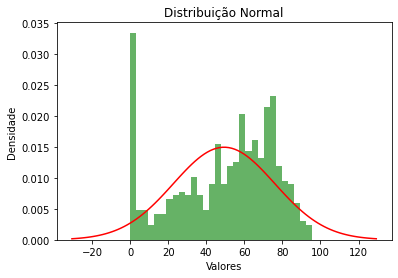

In [ ]:
# Plotar o histograma dos dados
plt.hist(df_cdc['CRA'], bins=30, density=True, alpha=0.6, color='g')

# Gerar pontos para a curva teórica da distribuição normal
mu, sigma = np.mean(df_cdc['CRA']), np.std(df_cdc['CRA'])
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x - mu)**2 / (2*sigma**2))

# Plotar a curva teórica da distribuição normal
plt.plot(x, y, color='r')

# Configurar o título e os rótulos dos eixos
plt.title('Distribuição Normal')
plt.xlabel('Valores')
plt.ylabel('Densidade')

# Exibir o gráfico
plt.show()


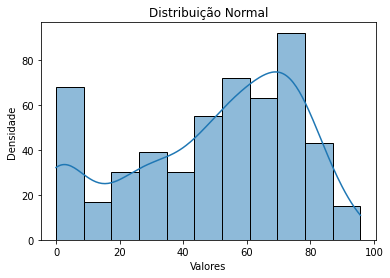

In [ ]:
sns.histplot(df_cdc['CRA'], kde=True)
plt.title('Distribuição Normal')
plt.xlabel('Valores')
plt.ylabel('Densidade')
plt.show()

A partir desse resultado, percebeu-se que o padrão está desacordo com a distribuição normal.

A partir disso, foi pensado que se os valores de CRA igual a 0 fossem retirados, poderia melhorar a distribuição:

In [ ]:
df_cdc_CRA_diferente_zero = df_cdc[df_cdc['CRA'] != 0]

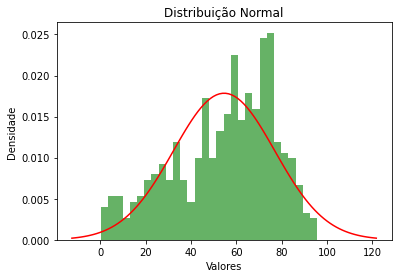

In [ ]:
# Plotar o histograma dos dados
plt.hist(df_cdc_CRA_diferente_zero['CRA'], bins=30, density=True, alpha=0.6, color='g')

# Gerar pontos para a curva teórica da distribuição normal
mu, sigma = np.mean(df_cdc_CRA_diferente_zero['CRA']), np.std(df_cdc_CRA_diferente_zero['CRA'])
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x - mu)**2 / (2*sigma**2))

# Plotar a curva teórica da distribuição normal
plt.plot(x, y, color='r')

# Configurar o título e os rótulos dos eixos
plt.title('Distribuição Normal')
plt.xlabel('Valores')
plt.ylabel('Densidade')

# Exibir o gráfico
plt.show()

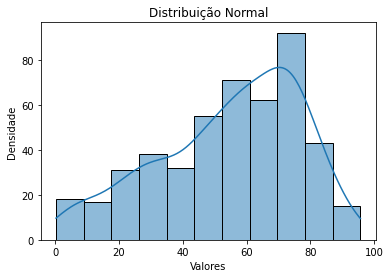

In [ ]:
sns.histplot(df_cdc_CRA_diferente_zero['CRA'], kde=True)
plt.title('Distribuição Normal')
plt.xlabel('Valores')
plt.ylabel('Densidade')
plt.show()

Entretanto, mesmo retirando os valores iguais a 0, a distribuição não segue uma normalidade, portanto, isso significa que eles não possuem a forma de sino simétrica típica da distribuição normal

## **Pergunta 2**: Ao analisar a taxa de evasão por gênero, o que se pode concluir?

In [ ]:
df_mulheres_cdc = dados[(dados['Sexo'] == 'F')]
df_homens_cdc = dados[(dados['Sexo'] == 'M')]

qtd_mulheres_cdc = df_mulheres_cdc['Sexo'].shape[0]
qtd_homens_cdc = df_homens_cdc['Sexo'].shape[0]

print(f'Quantidade de mulheres: {qtd_mulheres_cdc}')
print(f'Quantidade de homens: {qtd_homens_cdc}')

Quantidade de mulheres: 193
Quantidade de homens: 1397


In [ ]:
taxa_evasao_genero = dados.groupby('Sexo')['Situacao_Aluno_Agrupada'].apply(lambda x: (x == 'Evasão').mean())
taxa_evasao_genero

Sexo
F    0.362694
M    0.413744
Name: Situacao_Aluno_Agrupada, dtype: float64

In [ ]:
taxa_evasao_mulheres = taxa_evasao_genero[0]
taxa_evasao_homens = taxa_evasao_genero[1]

print(f'Taxa de evasão mulheres: {taxa_evasao_mulheres:.2f}')
print(f'Taxa de evasão homens: {taxa_evasao_homens:.2f}')

Taxa de evasão mulheres: 0.36
Taxa de evasão homens: 0.41


In [ ]:
qtd_mulheres_evasao = qtd_mulheres_cdc * taxa_evasao_mulheres
qtd_homens_evasao = qtd_homens_cdc * taxa_evasao_homens

print(f'Número de mulheres que evadiram: {round(qtd_mulheres_evasao)}')
print(f'Número de homens que evadiram: {round(qtd_homens_evasao)}')

Número de mulheres que evadiram: 70
Número de homens que evadiram: 578


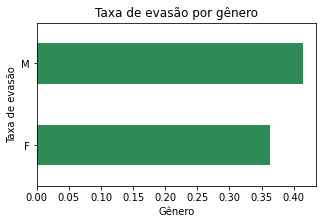

In [ ]:
taxa_evasao_genero.plot(kind="barh", figsize=(5,3), color="SeaGreen")
plt.title('Taxa de evasão por gênero')
plt.xlabel('Gênero')
plt.ylabel('Taxa de evasão')
plt.show()

> Após as análises da taxa de evasão para cada gênero, podemos concluir que temos uma taxa de evasão mais alta para os homens do que para as mulheres. Porém, ao considerar a perspectiva social do curso de Ciência da Computação e os números que informam a quantidade de cada gênero, percebemos que a quantidade de mulheres que passaram pelo curso, concluindo ele ou não, é extremamente menor que a dos homens, incluindo os dois campus. Dessa forma então, vale ressaltar que a quantidade de homens no curso influencia no alto valor da taxa de evasão.

## **Pergunta 3**: Número médio de alunos que ingressaram no curso durante a pandemia de COVID-19, onde se espera entender se o método de ensino remoto influenciou ou não na decisão de saída do curso.

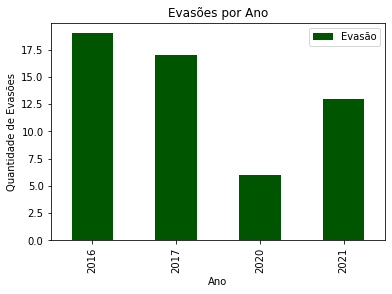

In [ ]:
admitido2016 = df_cdc[df_cdc['Admissao'].str.contains("2016")]
admitido2017 = df_cdc[df_cdc['Admissao'].str.contains("2017")]
admitido2020 = df_cdc[df_cdc['Admissao'].str.contains("2020")]
admitido2021 = df_cdc[df_cdc['Admissao'].str.contains("2021")]

evasao2016 = admitido2016[(admitido2016['Saida'].str.contains("2016")) | (admitido2016['Saida'].str.contains("2017"))].count()['Saida']
evasao2017 = admitido2017[(admitido2017['Saida'].str.contains("2017")) | (admitido2017['Saida'].str.contains("2018"))].count()['Saida']
evasao2020 = admitido2020[(admitido2020['Saida'].str.contains("2020")) | (admitido2020['Saida'].str.contains("2021"))].count()['Saida']
evasao2021 = admitido2021[(admitido2021['Saida'].str.contains("2021")) | (admitido2021['Saida'].str.contains("2022"))].count()['Saida']

data = {'Ano': ['2016', '2017', '2020', '2021'],
        'Evasão': [evasao2016, evasao2017, evasao2020, evasao2021]}
df_evasao = pd.DataFrame(data)

df_evasao.plot(x='Ano', y='Evasão', kind='bar', color='#005500')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Evasões')
plt.title('Evasões por Ano')
plt.show()


## **Pergunta 4:** Esperamos prever a quantidade de alunos, em porcentagem, por modalidade de ingresso abandonaram o curso.

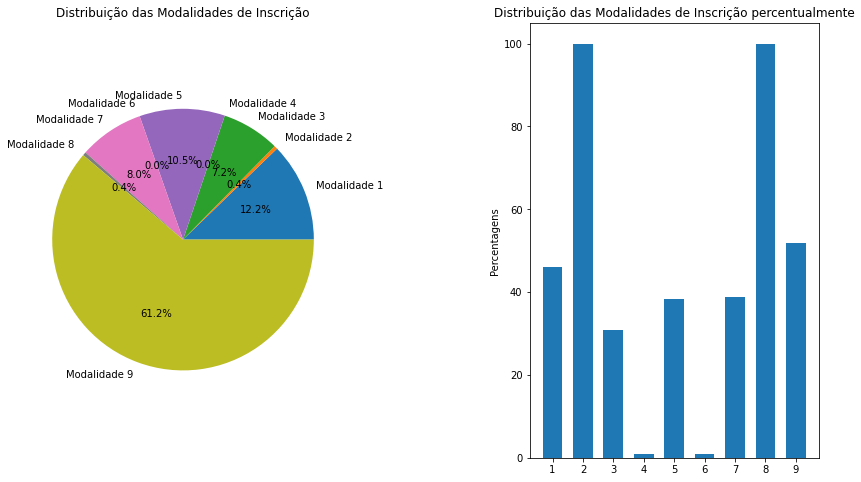

In [ ]:
percentagens = []



modalidade1 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 1) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade2 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 2) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade3 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 3) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade4 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 4) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade5 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 5) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade6 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 6) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade7 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 7) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade8 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 8) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()
modalidade9 = df_cdc[(df_cdc['Modalidade_Inscrita'] == 9) & (df_cdc['Situacao_Aluno_Agrupada'] == 'Evasão')].count()



modalidades = [modalidade1[0], modalidade2[0], modalidade3[0], modalidade4[0],
               modalidade5[0], modalidade6[0], modalidade7[0], modalidade8[0], modalidade9[0]]


modalidade1Total = df_cdc[(df_cdc['Modalidade_Inscrita'] == 1)].count()
modalidade2Total = df_cdc[(df_cdc['Modalidade_Inscrita'] == 2)].count()
modalidade3Total = df_cdc[(df_cdc['Modalidade_Inscrita'] == 3)].count()
modalidade4Total = df_cdc[(df_cdc['Modalidade_Inscrita'] == 4)].count()
modalidade5Total = df_cdc[(df_cdc['Modalidade_Inscrita'] == 5)].count()
modalidade6Total = df_cdc[(df_cdc['Modalidade_Inscrita'] == 6)].count()
modalidade7Total = df_cdc[(df_cdc['Modalidade_Inscrita'] == 7)].count()
modalidade8Total = df_cdc[(df_cdc['Modalidade_Inscrita'] == 8)].count()
modalidade9Total = df_cdc[(df_cdc['Modalidade_Inscrita'] == 9)].count()

modalidadesTotais = [modalidade1Total[0], modalidade2Total[0], modalidade3Total[0], modalidade4Total[0],
               modalidade5Total[0], modalidade6Total[0], modalidade7Total[0], modalidade8Total[0], modalidade9Total[0]]

for i in range(0,9):
  if(modalidadesTotais[i] == 0):
    percentagens.append(1)
  else:
    percentagens.append(modalidades[i] / modalidadesTotais[i] * 100)


labels = ['Modalidade 1', 'Modalidade 2', 'Modalidade 3', 'Modalidade 4',
          'Modalidade 5', 'Modalidade 6', 'Modalidade 7', 'Modalidade 8', 'Modalidade 9']


labelsPercentagem = ['1', '2', '3', '4',
          '5', '6', '7', '8', '9']


fig, ax = plt.subplots(1, 2, figsize=(14, 8))


ax[0].pie(modalidades, labels=labels, autopct='%1.1f%%')
ax[0].set_title('Distribuição das Modalidades de Inscrição')
ax[0].axis('equal')


x = np.arange(len(labels))
width = 0.65

ax[1].bar(x, percentagens, width)
ax[1].set_xticks(x)
ax[1].set_xticklabels(labelsPercentagem)
ax[1].set_ylabel('Percentagens')
ax[1].set_title('Distribuição das Modalidades de Inscrição percentualmente')


plt.subplots_adjust(wspace=0.7)


plt.show()

## **Pergunta 5:** Os alunos que vieram de escolas públicas tendem a abandonar o curso?

In [ ]:
df_cdc_modalidade = df_cdc.groupby('Modalidade_Inscrita').count()

qntdTotal_modalidade9 = df_cdc_modalidade.iloc[7:8].sum()[0]
print("Quantidade total de pessoas da modalidade 9 no curso inteiro: ",qntdTotal_modalidade9)

qntdTotal_modalidades1_a_8 = df_cdc_modalidade.iloc[1:7].sum()[0] # Não está contando a modalidade 0
print("Quantidade total de pessoas da modalidade 1 a 8 no curso inteiro: ",qntdTotal_modalidades1_a_8)


df_cdc_modalidade

Quantidade total de pessoas da modalidade 9 no curso inteiro:  280
Quantidade total de pessoas da modalidade 1 a 8 no curso inteiro:  234


,Identificador,Ano_Nascimento,Sexo,Campus,Curso_Identificador,Curso,UF_Nascimento,Municipio_Nascimento,Admissao,Saida,Codigo_Situacao_Aluno,Situacao_Aluno,Situacao_Aluno_Agrupada,ENEM,Num_Reprovacoes,Raca,CRA
Modalidade_Inscrita,,,,,,,,,,,,,,,,,
0.0,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
1.0,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63
2.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3.0,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55
5.0,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65
7.0,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49
8.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9.0,280,280,280,280,280,280,280,280,280,280,280,280,280,280,280,280,280


In [ ]:
df_cdc_abandono = df_cdc[df_cdc['Codigo_Situacao_Aluno'] == 'A']

df_cdc_abandono_modalidade = df_cdc_abandono.groupby('Modalidade_Inscrita').count()

qntdTotal_abandono_modalidade9 = df_cdc_abandono_modalidade.iloc[7:8].sum()[0]
print("Quantidade total de pessoas da modalidade 9 que abandonaram o curso: ",qntdTotal_abandono_modalidade9)

qntdTotal_abandono_modalidades1_a_8 = df_cdc_abandono_modalidade.iloc[1:7].sum()[0] # Não está contando a modalidade 0
print("Quantidade total de pessoas da modalidade 1 a 8 que abandonaram o curso: ",qntdTotal_abandono_modalidades1_a_8)

df_cdc_abandono_modalidade

Quantidade total de pessoas da modalidade 9 que abandonaram o curso:  103
Quantidade total de pessoas da modalidade 1 a 8 que abandonaram o curso:  64


,Identificador,Ano_Nascimento,Sexo,Campus,Curso_Identificador,Curso,UF_Nascimento,Municipio_Nascimento,Admissao,Saida,Codigo_Situacao_Aluno,Situacao_Aluno,Situacao_Aluno_Agrupada,ENEM,Num_Reprovacoes,Raca,CRA
Modalidade_Inscrita,,,,,,,,,,,,,,,,,
0.0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
1.0,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
2.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3.0,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
5.0,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
7.0,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
8.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
9.0,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103


In [ ]:
porcentagem_modalidade9 = (qntdTotal_abandono_modalidade9/qntdTotal_modalidade9) * 100

porcentagem_modalidade1_a_8 = (qntdTotal_abandono_modalidades1_a_8/qntdTotal_modalidades1_a_8)  * 100

print("Porcentagem de pessoas que abandonaram o curso da modalidade 9:", porcentagem_modalidade9,"%\n")
print("Porcentagem de pessoas que abandonaram o curso das modalidades 1 a 8:", porcentagem_modalidade1_a_8,"%\n")

Porcentagem de pessoas que abandonaram o curso da modalidade 9: 36.78571428571429 %

Porcentagem de pessoas que abandonaram o curso das modalidades 1 a 8: 27.350427350427353 %



De acordo com os dados calculados, não necessariamente as pessoas que vieram de escola pública tendem a abandonar o curso, pois, analisando os dados, em torno de 280 alunos que entraram pela ampla concorrência, 103, ou seja, 36.80% abandonaram o curso, em contrapartida, de 234 alunos que entraram pelas modalidades inclusivas de escolas públicas, apenas 64, ou seja, 27.40% abandonaram o curso.

## **Pergunta 6**: Visamos calcular o valor médio de reprovações que os alunos que evadiram tiveram e analisar se há um padrão ou intervalo de números que aparecem de forma frequente.

In [ ]:
df_alunos_evadiram = dados[dados['Situacao_Aluno_Agrupada'] == 'Evasão']

In [ ]:
# Converter a coluna de object para int
df_alunos_evadiram['Num_Reprovacoes'] = df_alunos_evadiram['Num_Reprovacoes'].astype(int)

In [ ]:
# Calcular a frequência dos valores de reprovações
frequencia_reprovacoes = df_alunos_evadiram['Num_Reprovacoes'].value_counts().sort_index()

# Imprimir a tabela de frequência
print(f'Tabela de Frequência das Reprovações:')
print(f'(Número de reprovações/Quantidade de alunos)')
print(frequencia_reprovacoes)

Tabela de Frequência das Reprovações:
(Número de reprovações/Quantidade de alunos)
0     23
1     23
2     34
3     30
4     59
5     83
6     37
7     35
8     35
9     45
10    36
11    34
12    20
13    28
14    22
15    21
16    17
17    22
18    14
19     7
20     7
21     3
22     6
23     2
24     1
25     2
26     1
27     1
Name: Num_Reprovacoes, dtype: int64


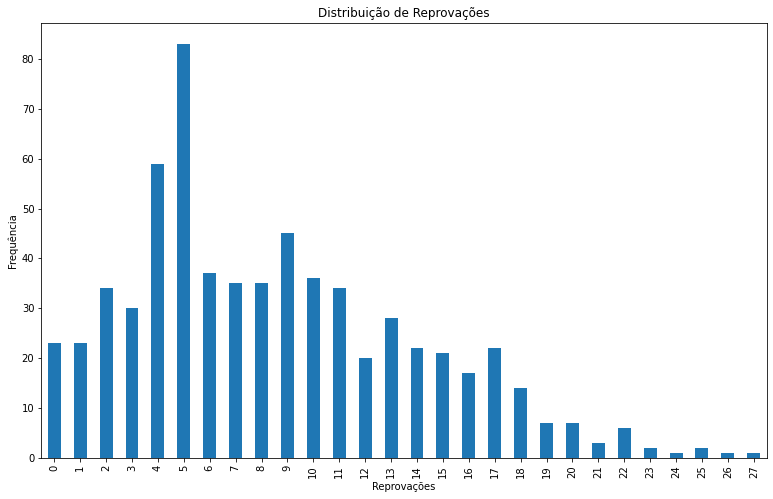

In [ ]:
plt.figure(figsize=(13, 8))
frequencia_reprovacoes.plot(kind='bar')
plt.xlabel('Reprovações')
plt.ylabel('Frequência')
plt.title('Distribuição de Reprovações')
plt.show()

> Podemos observar um pico na frequência em torno de 5 reprovações e uma tendência de diminuição à medida que o número de reprovações aumenta ou diminui em relação a esse pico. Isso pode indicar que a maioria dos alunos que evadiu apresentava em torno de 5 reprovações.

## **Pergunta 7**: Qual a média de idade das pessoas que decidiram abandonar o curso. O aluno ser mais velho ou mais novo influencia na decisão de saída?

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def remove_suffix1(entry):
    return entry.split('/1')[0]
def remove_suffix2(entry):
    return entry.split('/2')[0]
df_cdc_abandono = df_cdc[df_cdc['Codigo_Situacao_Aluno'] == 'A']

df_cdc_abandono['Saida'] = df_cdc_abandono['Saida'].apply(remove_suffix1)
df_cdc_abandono['Saida'] = df_cdc_abandono['Saida'].apply(remove_suffix2)

df_cdc_abandono = df_cdc_abandono[df_cdc_abandono['Saida'] != 0]
df_cdc_abandono['Saida'] = df_cdc_abandono['Saida'].astype(float)
df_cdc_abandono['IdadeAbandono'] = df_cdc_abandono['Saida'] - df_cdc_abandono['Ano_Nascimento']

media = df_cdc_abandono['IdadeAbandono'].mean()
print("Média da idade das pessoas que abandonaram o curso: ",media)

groupIdade = df_cdc_abandono.groupby('IdadeAbandono').count()

qntdIdade18_a_21 = groupIdade.head(4).sum()
somaIdades = groupIdade.sum()[0]

porcentagem_18_a_21 = (qntdIdade18_a_21/somaIdades) * 100
print("Porcentagem de pessoas que abandonaram o curso que possuem entre 18 a 21 anos:", porcentagem_18_a_21[0],"%\n")
groupIdade


Média da idade das pessoas que abandonaram o curso:  21.16470588235294
Porcentagem de pessoas que abandonaram o curso que possuem entre 18 a 21 anos: 71.76470588235294 %



,Identificador,Ano_Nascimento,Sexo,Campus,Curso_Identificador,Curso,UF_Nascimento,Municipio_Nascimento,Admissao,Saida,Codigo_Situacao_Aluno,Situacao_Aluno,Situacao_Aluno_Agrupada,Modalidade_Inscrita,ENEM,Num_Reprovacoes,Raca,CRA
IdadeAbandono,,,,,,,,,,,,,,,,,,
18.0,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36,36
19.0,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41
20.0,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25
21.0,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
22.0,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
23.0,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
24.0,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
25.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
26.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


Vale analisar que a média da idade das pessoas que abandonaram o curso é de 21 anos.

A quantidade de pessoas mais novas que abandonam o curso, por cerca de 18,19,20 e 21 são bem maiores do que as pessoas maiores de 23 anos, visto que, pelos cálculos, há 136 pessoas que abandonaram o curso estando nessas faixas de idade, em torno de 70.46% do total que abandonaram. Portanto, vale analisar, por meio desses dados, que as pessoas da faixa etária de jovens-adultos são os alunos que mais tendem a abandonar o curso.

## **Pergunta 8:**  Qual a relação entre a nota do ENEM e a evasão do curso?

Para compreender se existe uma relação entre as duas variáveis e caso exista, o quão fortemente relacionandas elas são, usaremos uma regressão logística.

In [ ]:
df = df_filtro

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, f1_score

df['Situacao_Num'] = df['Situacao_Aluno_Agrupada'].map({'Evasão': 0, 'Conclusão': 1})
df['ENEM'] = df['ENEM'].astype(float)

# Realizar a regressão logística
X = df[['ENEM']]
X = sm.add_constant(X)  # Adicionar uma coluna de 1s para o termo de interceptação
y = df['Situacao_Num']

logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())
print(f"\nR²: {result.prsquared:.4f}")

y_pred = result.predict(X) > 0.5  # Definir um limiar de 0.5 para a classificação
accuracy = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)

# Cálculo do odds ratio
coef = result.params['ENEM']
odds_ratio = np.exp(coef)

print(f"F1 Score: {f1:.4f}")
print(f"Odds Ratio: {odds_ratio:.4f}")

Optimization terminated successfully.
         Current function value: 0.638854
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:           Situacao_Num   No. Observations:                54753
Model:                          Logit   Df Residuals:                    54751
Method:                           MLE   Df Model:                            1
Date:                Sat, 08 Jul 2023   Pseudo R-squ.:                 0.07726
Time:                        20:40:52   Log-Likelihood:                -34979.
converged:                       True   LL-Null:                       -37908.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6792      0.012     56.211      0.000       0.655       0.703
ENEM          -0.0021   2.88e

Analisando as métricas do modelo podemos concluir que:

1. O coeficiente de determinação, ou R², de 0.0773 indica que apenas cerca de 7,73% da variabilidade da variável dependente é explicada pelas variáveis independentes do modelo, ou seja, que a situação do aluno não é totalmente explicada pelas variáveis independentes incluídas no modelo de regressão logística. Em outras palavras, o valor de R² sugere que a nota do ENEM  tem um poder explicativo limitado na predição da situação do aluno (evasão ou conclusão). Isso significa que outros fatores além da nota do ENEM provavelmente têm um papel significativo na determinação da evasão ou conclusão dos alunos.

2. O F1 Score de 0.6959 é uma medida da precisão do modelo na classificação correta dos dados. Ele é calculado com base na média harmônica da precisão (capacidade de prever corretamente as instâncias positivas) e da recall (capacidade de identificar corretamente as instâncias positivas). O valor de 0.6959 indica um desempenho moderado  do modelo na classificação correta das instâncias positivas.

3. O valor de odds ratio de é uma medida usada em análise estatística para comparar a probabilidade de um evento ocorrer em um grupo em relação a outro grupo. Um valor de 0.9979 próximo a 1 indica que as chances do evento ocorrer são praticamente as mesmas nos dois grupos comparados. Isso sugere que não há uma diferença substancial nas chances do evento ocorrer entre os grupos.

Em resumo, as métricas indicam que o modelo possui um baixo poder de explicação da variabilidade dos dados (R² baixo), um desempenho moderado na classificação (F1 Score moderado) e não há uma diferença significativa nas chances de o evento ocorrer entre os grupos (Odds Ratio próximo a 1).



## **Pergunta 9**: Há evidências de que uma quantidade relevante de alunos que abandonaram o curso não são de Minas Gerais, estado onde os campus se localiza?



Ao analisar a distribuição geográfica dos alunos que abandonaram o curso, podemos observar se há uma concentração significativa de alunos de outros estados em relação a Minas Gerais.


In [ ]:
df = dados

In [ ]:
df['Curso'].unique()

array(['CAV - Ciência da Computação', 'CAF - Ciência da Computação'],
      dtype=object)

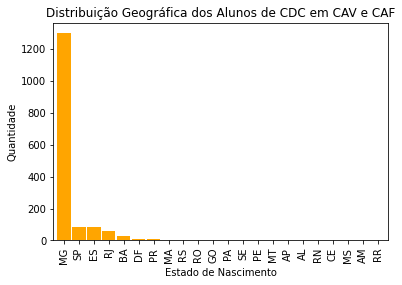

In [ ]:
# Contagem de alunos por estado de nascimento
estado_nascimento_counts = df['UF_Nascimento'].value_counts()

# Gráfico de barras mostrando a distribuição geográfica
estado_nascimento_counts.plot(kind='bar', color='orange', width=0.9)
plt.xlabel('Estado de Nascimento')
plt.ylabel('Quantidade')
plt.title('Distribuição Geográfica dos Alunos de CDC em CAV e CAF')
plt.show()

In [ ]:
df_mg = df[(df['UF_Nascimento'] == 'MG')]
df_fora_mg = df[(df['UF_Nascimento'] != 'MG')]

qtd_mg = df_mg['Identificador'].shape[0]
qtd_fora_mg = df_fora_mg['Identificador'].shape[0]

print(f'Quantidade de alunos que são de MG: {qtd_mg}')
print(f'Quantidade de alunos que não são de MG: {qtd_fora_mg}')

Quantidade de alunos que são de MG: 1299
Quantidade de alunos que não são de MG: 291


In [ ]:
qtd_evasao_mg = df_mg[df_mg['Situacao_Aluno_Agrupada'] == 'Evasão'].shape[0]
qtd_evasao_nao_mg = df_fora_mg[df_fora_mg['Situacao_Aluno_Agrupada'] == 'Evasão'].shape[0]

print(f'Quantidade de alunos que evadiram e são de MG: {qtd_evasao_mg}')
print(f'Quantidade de alunos que evadiram e não são de MG: {qtd_evasao_nao_mg}')

Quantidade de alunos que evadiram e são de MG: 544
Quantidade de alunos que evadiram e não são de MG: 104


In [ ]:
taxa_evasao_mg = (qtd_evasao_mg / qtd_mg)
taxa_evasao_fora_mg = (qtd_evasao_nao_mg / qtd_fora_mg)

print(f'Taxa de evasão dos alunos que são de MG: {taxa_evasao_mg:.4f}')
print(f'Taxa de evasão dos alunos que não são de MG: {taxa_evasao_fora_mg:.4f}')

Taxa de evasão dos alunos que são de MG: 0.4188
Taxa de evasão dos alunos que não são de MG: 0.3574


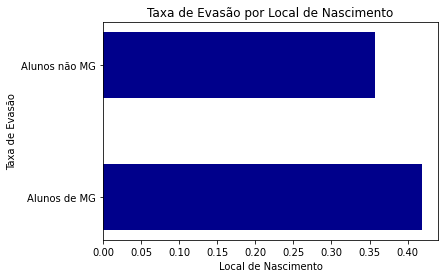

In [ ]:
taxas = [taxa_evasao_mg, taxa_evasao_fora_mg]
categorias = ['Alunos de MG', 'Alunos não MG']

plt.barh(categorias, taxas, height=0.5, color='DarkBlue')
plt.title('Taxa de Evasão por Local de Nascimento')
plt.xlabel('Local de Nascimento')
plt.ylabel('Taxa de Evasão')

plt.show()

> Como consideramos apenas os campus CAF e CAV, ao calcular a taxa de evasão foi possível observar que os alunos de MG evadem mais (cerca de 42%) do que os que não são de MG (cerca de 36%).  Porém esses percentuais de evasão são próximos, e analisando de uma visão social e geográfica pensamos que fatores como o histórico do curso (considerando as matérias que são estudadas, o nível de dificuldade, a diferença entre número de alunos que são de MG e os que não são e também a decisão de com quais dados trabalhamos, podem ter influenciado nesses resultados. Além de considerarmos que a região oferece outras oportunidades de estudo e o fato de que quem mora longe, já passou por uma grande mudança.


## Mapeamento dos dados

In [ ]:
#evadiu = 0
#formou = 1
dados = df_filtro[(df_filtro['Curso'] == 'CAF - Ciência da Computação') | (df_filtro['Curso'] == 'CAV - Ciência da Computação')]
mean_value = dados.loc[dados['ENEM'] != -1, 'ENEM'].mean()

map_evasao = {'Evasão': 0, 'Conclusão': 1}
dados['Situacao_Aluno_Agrupada'] = df['Situacao_Aluno_Agrupada'].map(map_evasao)
# Replace -1 values with the mean
dados.loc[dados['ENEM'] == -1, 'ENEM'] = mean_value

C:\Users\cotoq\AppData\Local\Temp\ipykernel_17148\1959357792.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados['Situacao_Aluno_Agrupada'] = df['Situacao_Aluno_Agrupada'].map(map_evasao)


## Conjuntos de Teste

In [ ]:
X1 = dados[['ENEM', 'Num_Reprovacoes', 'CRA']]
X2 = dados[['Num_Reprovacoes','CRA']]
X3 = dados[['Num_Reprovacoes','ENEM']]
y = dados['Situacao_Aluno_Agrupada']

## **Árvore de Decisões**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.model_selection import cross_validate


def avaliar_modelos_arvore_decisao(X, y):
    modelos = []

    metricas = {
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='weighted')
    }

    for i, X_atual in enumerate(X):
        modelo = DecisionTreeClassifier(random_state=42)
        scores = cross_validate(modelo, X_atual, y, cv=5, scoring=metricas)

        modelos.append(modelo)

        print(f"\nConjunto de Teste X{i+1}:")
        print("Acurácia:", scores['test_accuracy'].mean())
        print("F1-Score:", scores['test_f1'].mean())
        print("\n------------------------------------------------------------")

    return modelos

In [ ]:
modelos = avaliar_modelos_arvore_decisao([X1, X2, X3], y)


Conjunto de Teste X1:
Acurácia: 0.8661157024793388
F1-Score: 0.8647139884534383

------------------------------------------------------------

Conjunto de Teste X2:
Acurácia: 0.8702479338842976
F1-Score: 0.8697459640639815

------------------------------------------------------------

Conjunto de Teste X3:
Acurácia: 0.5933884297520662
F1-Score: 0.5610202288607139

------------------------------------------------------------


## **SVM**

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn import svm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
warnings.filterwarnings('ignore')

def avaliar_modelo_SVM(X_variables, y):
    i = 0
    for x in X_variables:
        i += 1
        svm_model = svm.SVC(kernel='linear', probability=True)

        # Perform cross-validation
        scores = cross_val_score(svm_model, x, y, cv=5)
        svm_accuracy = scores.mean()
        svm_accuracy_std = scores.std()

        print(f"\nConjunto de Teste X{i}:")
        print('Acurácia SVM: {:.4f} (± {:.4f})'.format(svm_accuracy, svm_accuracy_std))



X_variables = [X1, X2, X3]
avaliar_modelo_SVM(X_variables, y)


Conjunto de Teste X1:
Acurácia SVM: 0.9223 (± 0.0333)

Conjunto de Teste X2:
Acurácia SVM: 0.9223 (± 0.0332)

Conjunto de Teste X3:
Acurácia SVM: 0.6132 (± 0.0792)


## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

X_variables = [X1, X2, X3]
counter = 1
knn = KNeighborsClassifier()
for var in X_variables:
    acc = cross_val_score(knn, var, y, cv=5)
    print(f"Conjunto de variáveis X{counter}:")
    knn.fit(var, y)

    knn_Y_predicted = knn.predict(var)
    knn_accuracy = np.sum(knn_Y_predicted == y) / len(y)

    print('\t-Precisão do modelo: {:.2f}%'.format(100 * knn_accuracy))
    print(f"\t-Média da precisão com validação cruzada: {100 * np.mean(acc):.3f}%\n")
    counter+=1

Conjunto de variáveis X1:
	-Precisão do modelo: 93.88%
	-Média da precisão com validação cruzada: 88.843%

Conjunto de variáveis X2:
	-Precisão do modelo: 93.47%
	-Média da precisão com validação cruzada: 92.066%

Conjunto de variáveis X3:
	-Precisão do modelo: 73.80%
	-Média da precisão com validação cruzada: 63.884%



In [ ]:
print(y.describe)

<bound method NDFrame.describe of 1017     Conclusão
1018     Conclusão
1189     Conclusão
1190     Conclusão
1191     Conclusão
           ...    
73173       Evasão
73231       Evasão
73234       Evasão
73317       Evasão
73321       Evasão
Name: Situacao_Aluno_Agrupada, Length: 1210, dtype: object>


## Rede Neural

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

X_variables = [X1, X2, X3]

for i, X in enumerate(X_variables):
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=X_train_split.shape[1]))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(f"Training Model {i+1}")
    model.fit(X_train_split, y_train_split, epochs=100, verbose=0, batch_size=32, validation_data=(X_val_split, y_val_split))
    _, accuracy = model.evaluate(X_val_split, y_val_split, verbose=0)
    print(f"Accuracy for Model {i+1}: {accuracy}")



Training Model 1
Accuracy for Model 1: 0.8512396812438965
Training Model 2
Accuracy for Model 2: 0.8429751992225647
Training Model 3
Accuracy for Model 3: 0.6322314143180847


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def avaliar_modelo_RF(X_variables, y):
    i = 0
    for x in X_variables:
        i += 1
        rf_model = RandomForestClassifier()

        # Perform cross-validation
        scores = cross_val_score(rf_model, x, y, cv=5)
        rf_accuracy = scores.mean()
        rf_accuracy_std = scores.std()

        print(f"\nConjunto de Teste X{i}:")
        print('Acurácia Random Forest: {:.4f} (± {:.4f})'.format(rf_accuracy, rf_accuracy_std))

X_variables = [X1, X2, X3]
avaliar_modelo_RF(X_variables, y)


Conjunto de Teste X1:
Acurácia Random Forest: 0.8975 (± 0.0301)

Conjunto de Teste X2:
Acurácia Random Forest: 0.8818 (± 0.0294)

Conjunto de Teste X3:
Acurácia Random Forest: 0.6198 (± 0.0649)
